In [1]:
#Choose GPUs and CPUs

#If want to choose GPU to use
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"

import tensorflow as tf
from keras import backend as K

GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Using TensorFlow backend.


# Reload all data from before

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import backend as K
from keras.utils import to_categorical

data_root = '.'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
ifile=open(pickle_file, 'r')
data=pickle.load(ifile)
ifile.close()

train_dataset=data['train_dataset']
train_labels=data['train_labels']
valid_dataset=data['valid_dataset']
valid_labels=data['valid_labels']
test_dataset=data['test_dataset']
test_labels=data['test_labels']
print ("Done")


train_labels=to_categorical(train_labels) #One-hot encoding, converts label to vector
test_labels=to_categorical(test_labels)               #with one 1 and rest 0s
print (train_labels.shape)

Done
(200000, 10)


# Copy data to 3 channels and resample to get 56x56 images

In [3]:
dims=train_dataset.shape
print (dims)
trainee=train_dataset.reshape(dims[0],dims[1],dims[2],1)
dims=test_dataset.shape
testee=test_dataset.reshape(dims[0],dims[1],dims[2],1)
print (trainee.shape)

dims=train_dataset.shape
print (dims)
print (trainee.shape)
#VGG needs 3 channels, so repeat data
from tqdm import tqdm
dims=dims+(3,)#--THIS IS NEAT!
print (dims)
dataset3=np.zeros(dims,float)
for i in tqdm(range(dims[0])):
    dataset3[i,:,:,0],dataset3[i,:,:,1],dataset3[i,:,:,2]=train_dataset[i,:,:],train_dataset[i,:,:],train_dataset[i,:,:]

  4%|▍         | 7827/200000 [00:00<00:02, 78238.74it/s]

(200000, 28, 28)
(200000, 28, 28, 1)
(200000, 28, 28)
(200000, 28, 28, 1)
(200000, 28, 28, 3)


100%|██████████| 200000/200000 [00:02<00:00, 89893.63it/s]


In [4]:
print (dataset3.shape)
#VGG needs atleast 48x48, so resample
def resample(diff3D,Nx,Ny): #Center and resample diffraction array to desired pixel spacing
    nx, ny, nz = diff3D.shape
    diff3D=zoom(diff3D, (float(Nx)/nx,float(Ny)/ny, 1), order=1)
    return diff3D

data=[]
from scipy.ndimage.interpolation import zoom
for i in tqdm(range(dims[0])):
    tmp=resample(dataset3[i,:,:,:],56,56)
    data.append(tmp)

dataset3=np.asarray(data)
print (dataset3.shape)

  0%|          | 114/200000 [00:00<02:55, 1136.99it/s]

(200000, 28, 28, 3)


100%|██████████| 200000/200000 [02:52<00:00, 1162.41it/s]


(200000, 56, 56, 3)


(28, 28, 3)
-0.5


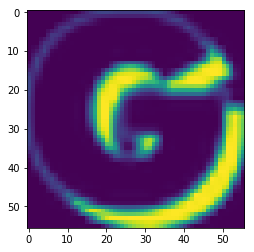

In [5]:
tmp=np.asarray([train_dataset[0,:,:],train_dataset[0,:,:],train_dataset[0,:,:]]).T
print (tmp.shape)
print (np.min(train_dataset[0,:,:])), (np.max(train_dataset[0,:,:]))

plt.imshow(dataset3[2,:,:,1])

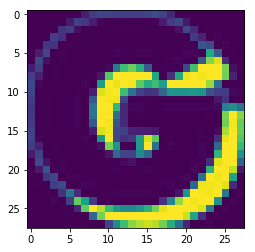

In [6]:
plt.imshow(train_dataset[2,:,:])

In [7]:
K.clear_session()
batch_size=200
epochs=10
Nc=56
n_labels=10
labels=train_labels

import keras
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model, load_model
from keras.layers import GlobalMaxPooling2D
from keras.utils import np_utils

base_model=VGG16(input_shape=(Nc,Nc,3), 
                 weights='imagenet', include_top=False)
#base_model.layers.pop() #Pop out the current logistic layer
tmp = base_model.output

#Add a fully connected layer
tmp=Flatten()(tmp)
#tmp=GlobalMaxPooling2D(data_format='channels_last')(tmp)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(n_labels, activation='softmax')(tmp)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:15]:
    layer.trainable = False #Fix the first 15 layers
    
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#Initial learning rate of 0.001, which is smaller than the learning rate for training scratch model (usually 0.01).
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#Save model every epoch
checkpoints=keras.callbacks.ModelCheckpoint('vgg_weights/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

print (model.summary())

#                print "Training ..."
history=model.fit(dataset3, labels,
                #np_utils.to_categorical(labels,n_labels),  
                batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.1, callbacks=[checkpoints])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0         
__________

In [37]:
model.save('current.h5')
hist=history
epochs=np.asarray(history.epoch)+1

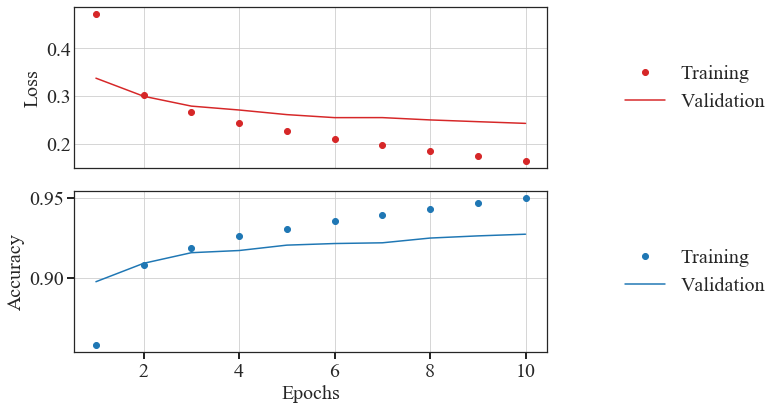

In [38]:
%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(2, sharex=True, figsize=(8, 6))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))


axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)

#plt.savefig('figs/x_iters.png', dpi=200)

# Test data

In [31]:
dims=test_dataset.shape
dims=dims+(3,)#--THIS IS NEAT!
print (dims)
test3=np.zeros(dims,float)
for i in tqdm(range(dims[0])):
    test3[i,:,:,0],test3[i,:,:,1],test3[i,:,:,2]=test_dataset[i,:,:],test_dataset[i,:,:],test_dataset[i,:,:]

100%|██████████| 10000/10000 [00:00<00:00, 87057.23it/s]

(10000, 28, 28, 3)


In [32]:
print (test3.shape)
#VGG needs atleast 48x48, so resample
def resample(diff3D,Nx,Ny): #Center and resample diffraction array to desired pixel spacing
    nx, ny, nz = diff3D.shape
    diff3D=zoom(diff3D, (float(Nx)/nx,float(Ny)/ny, 1), order=1)
    return diff3D

data=[]
from scipy.ndimage.interpolation import zoom
for i in tqdm(range(dims[0])):
    tmp=resample(test3[i,:,:,:],56,56)
    data.append(tmp)

test3=np.asarray(data)
print (test3.shape)

  1%|          | 122/10000 [00:00<00:08, 1210.41it/s]

(10000, 28, 28, 3)


100%|██████████| 10000/10000 [00:08<00:00, 1175.15it/s]


(10000, 56, 56, 3)


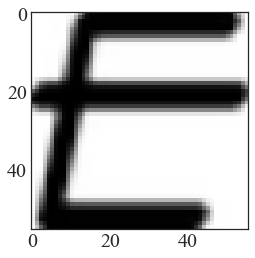

In [39]:
plt.imshow(test3[2,:,:,0])

In [41]:
score=model.evaluate(test3, test_labels, verbose=1)
print (score)

10000/10000 [==============================] - 17s 2ms/step
[0.091249067724496133, 0.9728]
